In [87]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

## LOAD DATASET

In [62]:
DATA_DIR = "./Processed_data_shrink"
train_files = sorted(glob.glob(os.path.join(DATA_DIR, "1_*.csv")))
test_files  = sorted(glob.glob(os.path.join(DATA_DIR, "2_*.csv")))
train_files, test_files

(['./Processed_data_shrink\\1_sbj_0.csv',
  './Processed_data_shrink\\1_sbj_0_2.csv',
  './Processed_data_shrink\\1_sbj_1.csv',
  './Processed_data_shrink\\1_sbj_2.csv'],
 ['./Processed_data_shrink\\2_sbj_0.csv',
  './Processed_data_shrink\\2_sbj_0_2.csv',
  './Processed_data_shrink\\2_sbj_1.csv',
  './Processed_data_shrink\\2_sbj_2.csv'])

In [63]:
def load_multiple(files):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_train = load_multiple(train_files)
df_test  = load_multiple(test_files)

df_train.head()

,leg_acc_x,leg_acc_y,leg_acc_z,arm_acc_x,arm_acc_y,arm_acc_z,label
0,0.978287,-0.111472,0.103445,-0.956057,-0.407509,-0.090828,NaN
1,0.982915,-0.095342,0.083391,-1.167835,-0.088288,-0.131609,NaN
2,0.977757,-0.124765,0.113024,-1.063969,0.080970,-0.140224,NaN
3,0.988421,-0.056063,0.134405,-0.956582,0.273206,-0.157955,NaN
4,0.983513,-0.091392,0.095917,-0.927767,0.462559,-0.206675,NaN


## LABEL ENCODING

In [65]:
encode_label = {
    'jogging': 1,
    'jogging (rotating arms)': 2,
    'jogging (skipping)': 3,
    'jogging (sidesteps)': 4,
    'jogging (butt-kicks)': 5,
    'stretching (triceps)': 6,
    'stretching (lunging)': 7,
    'stretching (shoulders)': 8,
    'stretching (hamstrings)': 9,
    'stretching (lumbar rotation)': 10,
    'push-ups': 11,
    'push-ups (complex)': 12,
    'sit-ups': 13,
    'sit-ups (complex)': 14,
    'burpees': 15,
    'lunges': 16,
    'lunges (complex)': 17,
    'bench-dips': 18
}

# map labels
df_train["label"] = df_train["label"].map(encode_label).fillna(0).astype(int)
df_test["label"]  = df_test["label"].map(encode_label).fillna(0).astype(int)

In [66]:
mapped_train = df_train["label"]
mapped_test  = df_test["label"]
print("Mapped train:", pd.Series(mapped_train).unique()[:30])
print("Mappe test:", pd.Series(mapped_test).unique()[:30])

Mapped train: [ 0  1  6  2  7  3 11 12  4  8 13  9 14 16 15 10  5 18 17]
Mappe test: [ 0  1  6  2  7  3 11 12  4  8 13  9 14 16 15 10  5 18 17]


## FEATURE EXTRACTION

In [68]:
def extract_features(df, window_size=50, overlap=0):
    axes = [
        "arm_acc_x", "arm_acc_y", "arm_acc_z",
        "leg_acc_x", "leg_acc_y", "leg_acc_z"
    ]
    
    step = window_size - overlap
    n_windows = (len(df) - window_size) // step + 1
    
    n_features_per_axis = 9 
    n_features = len(axes) * n_features_per_axis + 8 
    features = np.zeros((n_windows, n_features))
    feature_names = []
    
    col_idx = 0
    
    for axis in axes:
        data = df[axis].values
        
        from numpy.lib.stride_tricks import sliding_window_view
        windows = sliding_window_view(data, window_size)[::step]
        
        features[:, col_idx] = windows.mean(axis=1)
        feature_names.append(f"{axis}_mean")
        col_idx += 1
        
        features[:, col_idx] = windows.std(axis=1)
        feature_names.append(f"{axis}_std")
        col_idx += 1
        
        features[:, col_idx] = windows.max(axis=1)
        feature_names.append(f"{axis}_max")
        col_idx += 1
        
        features[:, col_idx] = windows.min(axis=1)
        feature_names.append(f"{axis}_min")
        col_idx += 1
        
        features[:, col_idx] = np.median(windows, axis=1)
        feature_names.append(f"{axis}_median")
        col_idx += 1
        
        features[:, col_idx] = np.abs(windows).mean(axis=1)
        feature_names.append(f"{axis}_abs_mean")
        col_idx += 1
        
        features[:, col_idx] = np.abs(windows).max(axis=1)
        feature_names.append(f"{axis}_abs_max")
        col_idx += 1
        
        features[:, col_idx] = (windows**2).sum(axis=1)
        feature_names.append(f"{axis}_energy")
        col_idx += 1
        
        features[:, col_idx] = np.sqrt((windows**2).mean(axis=1))
        feature_names.append(f"{axis}_rms")
        col_idx += 1
    
    # SMV features
    from numpy.lib.stride_tricks import sliding_window_view
    
    arm_x = sliding_window_view(df["arm_acc_x"].values, window_size)[::step]
    arm_y = sliding_window_view(df["arm_acc_y"].values, window_size)[::step]
    arm_z = sliding_window_view(df["arm_acc_z"].values, window_size)[::step]
    arm_smv = np.sqrt(arm_x**2 + arm_y**2 + arm_z**2)
    
    features[:, col_idx] = arm_smv.mean(axis=1)
    feature_names.append("arm_smv_mean")
    col_idx += 1
    
    features[:, col_idx] = arm_smv.std(axis=1)
    feature_names.append("arm_smv_std")
    col_idx += 1
    
    features[:, col_idx] = arm_smv.max(axis=1)
    feature_names.append("arm_smv_max")
    col_idx += 1
    
    features[:, col_idx] = arm_smv.min(axis=1)
    feature_names.append("arm_smv_min")
    col_idx += 1
    
    leg_x = sliding_window_view(df["leg_acc_x"].values, window_size)[::step]
    leg_y = sliding_window_view(df["leg_acc_y"].values, window_size)[::step]
    leg_z = sliding_window_view(df["leg_acc_z"].values, window_size)[::step]
    leg_smv = np.sqrt(leg_x**2 + leg_y**2 + leg_z**2)
    
    features[:, col_idx] = leg_smv.mean(axis=1)
    feature_names.append("leg_smv_mean")
    col_idx += 1
    
    features[:, col_idx] = leg_smv.std(axis=1)
    feature_names.append("leg_smv_std")
    col_idx += 1
    
    features[:, col_idx] = leg_smv.max(axis=1)
    feature_names.append("leg_smv_max")
    col_idx += 1
    
    features[:, col_idx] = leg_smv.min(axis=1)
    feature_names.append("leg_smv_min")
    col_idx += 1
    
    return pd.DataFrame(features, columns=feature_names)

In [69]:
def get_windowed_labels(df, window_size=50, overlap=0):
    from numpy.lib.stride_tricks import sliding_window_view
    from scipy import stats
    
    step = window_size - overlap
    labels = df["label"].values
    label_windows = sliding_window_view(labels, window_size)[::step]
    windowed_labels = stats.mode(label_windows, axis=1, keepdims=False)[0]
    
    return pd.Series(windowed_labels, name="label")

In [70]:
window_size = 50
overlap = 0

X_train = extract_features_fast(df_train, window_size=window_size, overlap=overlap)
y_train = get_windowed_labels_fast(df_train, window_size=window_size, overlap=overlap)
X_test = extract_features_fast(df_test, window_size=window_size, overlap=overlap)
y_test = get_windowed_labels_fast(df_test, window_size=window_size, overlap=overlap)

In [71]:
# Split train thành train/valid (80/20)
split_idx = int(len(X_train) * 0.8)

X_train_split = X_train.iloc[:split_idx].reset_index(drop=True)
y_train_split = y_train.iloc[:split_idx].reset_index(drop=True)
X_valid = X_train.iloc[split_idx:].reset_index(drop=True)
y_valid = y_train.iloc[split_idx:].reset_index(drop=True)

print(f"Train size: {len(X_train_split)}")
print(f"Valid size: {len(X_valid)}")
print(f"Test size: {len(X_test)}")

Train size: 4550
Valid size: 1138
Test size: 5688


## XGBOOST MODEL

In [73]:
n_classes = len(np.unique(y_train))

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    n_estimators=50,          
    max_depth=4,              
    learning_rate=0.1,         
    subsample=0.8,             
    colsample_bytree=0.8,     
    tree_method='hist',       
    random_state=42,
    n_jobs=-1,                 
    eval_metric='mlogloss'
)

print("=== Training model ===")
model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_valid, y_valid)],
    verbose=True
)

y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

=== Training model ===
[0]	validation_0-mlogloss:2.36088	validation_1-mlogloss:2.57216
[1]	validation_0-mlogloss:2.03346	validation_1-mlogloss:2.37779
[2]	validation_0-mlogloss:1.80093	validation_1-mlogloss:2.23584
[3]	validation_0-mlogloss:1.61887	validation_1-mlogloss:2.11547
[4]	validation_0-mlogloss:1.46861	validation_1-mlogloss:2.03248
[5]	validation_0-mlogloss:1.34594	validation_1-mlogloss:1.95507
[6]	validation_0-mlogloss:1.23838	validation_1-mlogloss:1.88307
[7]	validation_0-mlogloss:1.14601	validation_1-mlogloss:1.83072
[8]	validation_0-mlogloss:1.06192	validation_1-mlogloss:1.77913
[9]	validation_0-mlogloss:0.98816	validation_1-mlogloss:1.73538
[10]	validation_0-mlogloss:0.92113	validation_1-mlogloss:1.69419
[11]	validation_0-mlogloss:0.86245	validation_1-mlogloss:1.66086
[12]	validation_0-mlogloss:0.80889	validation_1-mlogloss:1.62985
[13]	validation_0-mlogloss:0.75973	validation_1-mlogloss:1.59773
[14]	validation_0-mlogloss:0.71505	validation_1-mlogloss:1.57625
[15]	validat


=== Results ===
Valid Accuracy: 0.6125
Test Accuracy: 0.5327

=== Test Set - Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      1854
           1       0.81      0.77      0.79       285
           2       0.60      0.59      0.60       158
           3       0.51      0.85      0.64       204
           4       0.97      0.90      0.93       277
           5       0.77      0.36      0.49       200
           6       0.62      0.72      0.67       219
           7       0.49      0.34      0.40       221
           8       0.00      0.00      0.00       197
           9       0.26      0.17      0.20       178
          10       0.90      0.98      0.94       183
          11       0.00      0.00      0.00       177
          12       0.04      0.01      0.02       208
          13       0.00      0.00      0.00       239
          14       0.00      0.00      0.00       212
          15       1.00      0.

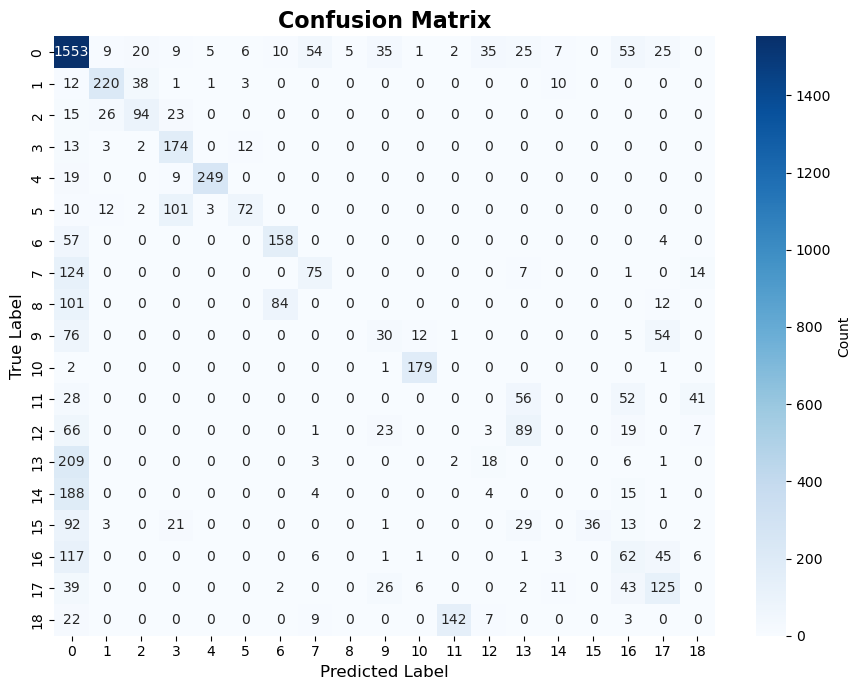

In [91]:
print("\n=== Results ===")
print(f"Valid Accuracy: {accuracy_score(y_valid, y_valid_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

print("\n=== Test Set - Classification Report ===")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print("\n=== Test Set - Confusion Matrix ===")
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(n_classes), 
            yticklabels=range(n_classes),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()